In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 14})

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.python.keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

## Load and Prepare Train and Test Data

In [5]:
# load in training data and labels generated in the synthetic_data_generation notebook
synth_matrix = np.load('synth_matrix.npy')
labels = np.load('labels.npy')

In [12]:
# turn synthetics and labels into dataframe, then do train test (70/30) split
df_synth_matrix = pd.DataFrame(synth_matrix)
df_labels = pd.DataFrame(labels)

np.random.seed(2345)
x = df_synth_matrix.iloc[:,:].astype(float)
y = df_labels.iloc[:].astype(float)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, shuffle = True, random_state=40)

# scale the synthetics using a minmax scaler (note we don't scale labels because they are already between 0.2 and 0.6)
scaler = MinMaxScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled  = scaler.fit_transform(xtest)

In [13]:
# calcualte the minimum and maximum values in the brittleness training labels
min_sig = round(np.min(np.array(ytrain)), 2)
max_sig = round(np.max(np.array(ytrain)), 2)
print('minimum for sigmoid = ', min_sig)
print('maximum for sigmoid = ', max_sig)

# use them in the scaled sigmoid output, to ensure that network doesn't predict values higher or lower than these
def sigmoid_scaled(x, lower=min_sig, upper=max_sig):
    scale = upper - lower
    return scale * tf.nn.sigmoid(x) + lower

get_custom_objects().update({'sigmoid_scaled': sigmoid_scaled})

minimum for sigmoid =  0.21
maximum for sigmoid =  0.59


# Random Forest model

In [21]:
# run hyperparameter grid search to find good parameters to use for the random forest regressor

param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 4, 6, 8],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rfr = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rfr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

%time
grid_search.fit(xtrain_scaled, ytrain)

In [23]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [32]:
# train and test RF with the best params

rfr = RandomForestRegressor(bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3,
                           min_samples_split=8, n_estimators=100)
rfr.fit(xtrain_scaled, np.ravel(ytrain))
ypred = rfr.predict(xtest_scaled)

print('Test MSE = ', mean_squared_error(ypred, np.ravel(ytest)))
print('Test R2 = ', r2_score(ypred, np.ravel(ytest)))

Test MSE =  0.00012344791549707645
Test R2 =  0.9672360561186003


# Define Neural Network Model Architectures

In [33]:
length_of_trace = 101
conv1_filters = 16
conv2_filters = 32
k = 3
dense_nodes = 250

# 1 dimensional CNN

def CNN(conv1_filters, conv2_filters, dense_nodes, k, pretrained_weights=None, input_size=[length_of_trace,1]):
    
    inputs = Input(input_size)
    
    layer1 = Conv1D(conv1_filters, kernel_size=k, activation='relu')(inputs) 
    layer2 = Conv1D(conv1_filters, kernel_size=k, activation='relu')(layer1) 
    layer3 = MaxPooling1D(pool_size=2)(layer2)

    layer4 = Conv1D(conv2_filters, kernel_size=k, activation='relu')(layer3)
    layer5 = Conv1D(conv2_filters, kernel_size=k, activation='relu')(layer4)
    layer6 = MaxPooling1D(pool_size=2)(layer5)

    layer7 = Flatten()(layer6) 

    layer8 = Dense(dense_nodes, activation = 'relu')(layer7) 
    layer9 = Dense(1, activation = sigmoid_scaled)(layer8) 

    model = Model(inputs=[inputs], outputs=[layer9])
    model.summary()
    
    return model

# Feed forward neural network

def FFNN(dense_nodes, pretrained_weights=None, input_size=[length_of_trace,1]):
    
    inputs = Input(input_size)
    
    layer1 = Dense(dense_nodes, activation='relu')(inputs) 
    layer2 = Flatten()(layer1)
    
    layer3 = Dense(1, activation=sigmoid_scaled)(layer2) 

    model = Model(inputs=[inputs], outputs=[layer3])
    model.summary()
    
    return model

### train and test feed forward neural network

In [37]:
%time
model_FFNN = FFNN(dense_nodes, pretrained_weights=None, input_size=[length_of_trace,1])

# use adam optimizer with initial learning rate of 1e-5. MSE as loss function.
model_FFNN.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

# use a batch size of 25 and train for 100 epochs
hist_FFNN = model_FFNN.fit(xtrain_scaled, ytrain, batch_size=25, epochs=100)

CPU times: total: 0 ns
Wall time: 0 ns
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 101, 1)]          0         
                                                                 
 dense_4 (Dense)             (None, 101, 250)          500       
                                                                 
 flatten_2 (Flatten)         (None, 25250)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25251     
                                                                 
Total params: 25,751
Trainable params: 25,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
84/84 [==============================] - 1s 4ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2/100
84/84 [====================

In [38]:
model_FFNN.save('model_FFNN.h5')

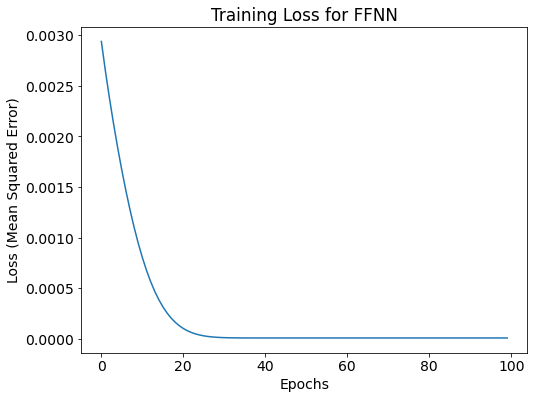

In [40]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(hist_FFNN.history['loss'])
ax.set_ylabel('Loss (Mean Squared Error)')
ax.set_xlabel('Epochs')
ax.set_title('Training Loss for FFNN')
#fig.savefig('FFNN_training_loss.jpg', dpi=1000, bbox_inches='tight')

In [42]:
# make prediction on test set
ypred_FFNN = model_FFNN.predict(xtest_scaled)

# change back into array form (output is annoying list and series formats)
ypred_FFNN = [i for i in ypred_FFNN]
ypred_FFNN = np.array(ypred_FFNN)
ypred_arr_FFNN = np.ndarray.flatten(ypred_FFNN)


print('Test MSE = ', mean_squared_error(ypred_arr_FFNN, np.ravel(ytest)))
print('Test R2 = ', r2_score(ypred_arr_FFNN, np.ravel(ytest)))

29/29 [==============================] - 0s 3ms/step
Test MSE =  0.00011658115604906504
Test R2 =  0.9676513894588664


### train and test 1D CNN

In [43]:
%time
model_CNN = CNN(conv1_filters, conv2_filters, dense_nodes, k, pretrained_weights=None, input_size=[length_of_trace,1])

# use adam optimizer with initial learning rate of 1e-5. MSE as loss function.
model_CNN.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

# use a batch size of 25 and train for 100 epochs
hist_CNN = model_CNN.fit(xtrain_scaled, ytrain, batch_size=25, epochs=100)

CPU times: total: 0 ns
Wall time: 0 ns
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 101, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 97, 16)            784       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 16)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 32)            1568      
                                                                 
 conv1d_3 (Conv1D)           (None, 44, 32)            3104      
                    

84/84 [==============================] - 0s 4ms/step - loss: 6.1094e-06 - mean_squared_error: 6.1094e-06
Epoch 56/100
84/84 [==============================] - 0s 4ms/step - loss: 5.7852e-06 - mean_squared_error: 5.7852e-06
Epoch 57/100
84/84 [==============================] - 0s 5ms/step - loss: 5.5173e-06 - mean_squared_error: 5.5173e-06
Epoch 58/100
84/84 [==============================] - 0s 4ms/step - loss: 5.2807e-06 - mean_squared_error: 5.2807e-06
Epoch 59/100
84/84 [==============================] - 0s 4ms/step - loss: 5.0423e-06 - mean_squared_error: 5.0423e-06
Epoch 60/100
84/84 [==============================] - 0s 5ms/step - loss: 4.8430e-06 - mean_squared_error: 4.8430e-06
Epoch 61/100
84/84 [==============================] - 0s 4ms/step - loss: 4.6362e-06 - mean_squared_error: 4.6362e-06
Epoch 62/100
84/84 [==============================] - 0s 5ms/step - loss: 4.4490e-06 - mean_squared_error: 4.4490e-06
Epoch 63/100
84/84 [==============================] - 0s 4ms/step - l

In [44]:
model_CNN.save('model_CNN.h5')

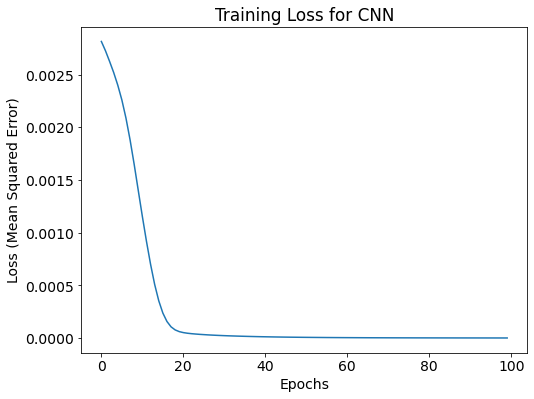

In [45]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(hist_CNN.history['loss'])
ax.set_ylabel('Loss (Mean Squared Error)')
ax.set_xlabel('Epochs')
ax.set_title('Training Loss for CNN')
#fig.savefig('CNN_training_loss.jpg', dpi=1000, bbox_inches='tight')

In [46]:
# make prediction on test set
ypred_CNN = model_CNN.predict(xtest_scaled)

# change back into array form (output is annoying list and series formats)
ypred_CNN = [i for i in ypred_CNN]
ypred_CNN = np.array(ypred_CNN)
ypred_arr_CNN = np.ndarray.flatten(ypred_CNN)


print('Test MSE = ', mean_squared_error(ypred_arr_CNN, np.ravel(ytest)))
print('Test R2 = ', r2_score(ypred_arr_CNN, np.ravel(ytest)))

29/29 [==============================] - 0s 2ms/step
Test MSE =  0.00012306689402952805
Test R2 =  0.9671324409136393


## Random Forest and both networks all converge to approximately the same error. We choose to use the CNN for future tests, since we plan to increase synthetic data complexity in future development of this project

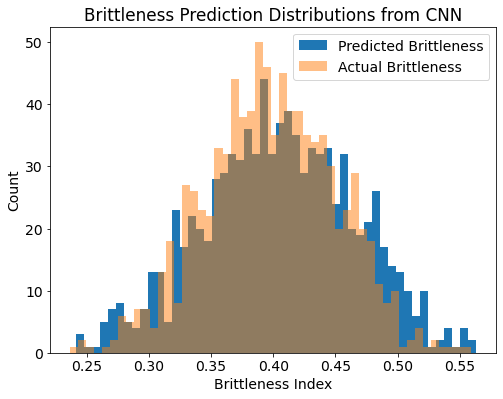

In [50]:
fig,ax = plt.subplots(figsize=(8,6))

ax.hist(ypred_arr_CNN, bins=50, label='Predicted Brittleness');
ax.hist(ytest, bins=50, label='Actual Brittleness', alpha=0.5);
ax.legend()
ax.set_xlabel('Brittleness Index')
ax.set_ylabel('Count')
ax.set_title('Brittleness Prediction Distributions from CNN')
#fig.savefig('predicted_vs_actual_brittleness_distributions_CNN.jpg', dpi=1000, bbox_inches='tight')

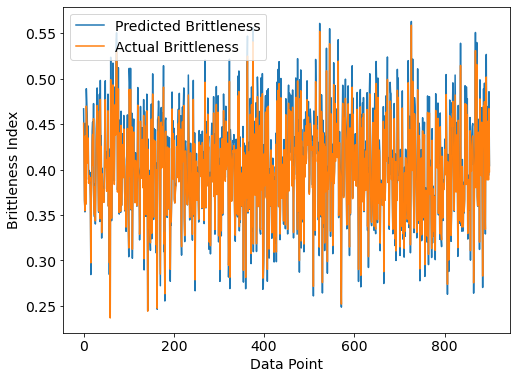

In [53]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(ypred_arr_CNN, label='Predicted Brittleness')
ax.plot(np.ravel(ytest), label='Actual Brittleness')

ax.set_ylabel('Brittleness Index')
ax.set_xlabel('Data Point')
ax.legend()
#fig.savefig('predicted_vs_actual_brittleness_datapoints_CNN.jpg', dpi=1000, bbox_inches='tight')